In [1]:
import pandas as pd
import numpy as np
import random
import argparse
import torch
from torch import nn
%load_ext autoreload
%autoreload 2


/home/coenraadmiddel/miniconda3/envs/saint_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_parquet(r'/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/train_processed.parquet')
print(train.shape)

(804056, 19)


In [3]:
train.columns.tolist()

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'CompetitionOpen',
 'PromoOpen',
 'IsPromoMonth',
 'Sales',
 'Set']

In [4]:
#select only a couple of columns

train = train[['Store',
                'DayOfWeek',
                'Promo',
                'StateHoliday',
                'SchoolHoliday',
                'StoreType',
                'Assortment',
                'CompetitionDistance',
                'Promo2SinceWeek',
                'Promo2SinceYear',
                'Year',
                'Month',
                'Day',
                'WeekOfYear',
                'CompetitionOpen',
                'PromoOpen',
                'IsPromoMonth',
                'Sales',
                'Set']]

In [5]:
random.seed(42)
if "Set" not in train.columns:
    train.reset_index(inplace=True, drop=True)
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

/home/coenraadmiddel/miniconda3/envs/saint_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/coenraadmiddel/miniconda3/envs/saint_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


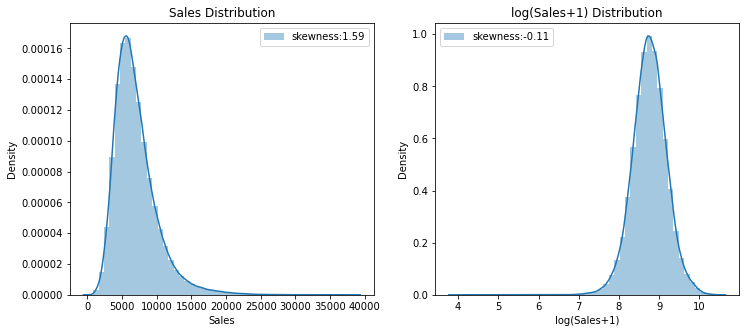

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# check distribution of sales in train set
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', 

ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [7]:
    
categorical_columns = ['Store',
                        'DayOfWeek',
                        'Promo',
                        'StateHoliday',
                        'SchoolHoliday',
                        'StoreType',
                        'Assortment',
                        # 'Year',
                        # 'Month',
                        # 'Day',
                        # 'WeekOfYear',
                        'IsPromoMonth']

In [8]:
train_indices

Int64Index([     0,      1,      2,      4,      5,      6,      8,      9,
                10,     11,
            ...
            804043, 804045, 804046, 804047, 804048, 804049, 804051, 804052,
            804054, 804055],
           dtype='int64', length=643484)

In [9]:
from data_openml import data_split

# split x and y
X_all, y_all = train.drop(columns = ['Sales', 'Set']), np.log1p(train[['Sales']].values)

temp = X_all.fillna("MissingValue")
nan_mask = temp.ne("MissingValue").astype(int)

X_train_d, y_train_d = data_split(X_all, y_all, nan_mask, train_indices)
X_valid_d, y_valid_d = data_split(X_all, y_all, nan_mask, valid_indices)
X_test_d, y_test_d = data_split(X_all, y_all, nan_mask, test_indices)


X_train = X_train_d['data']
X_test = X_test_d['data']
X_valid = X_valid_d['data']

y_train = y_train_d['data']
y_test = y_test_d['data']
y_valid = y_valid_d['data']



# X_train = X_all.values[train_indices]
# y_train = y_all.values[train_indices].reshape(-1, 1)

# X_valid = X_all.values[valid_indices]
# y_valid = y_all.values[valid_indices].reshape(-1, 1)

# X_test = X_all.values[test_indices]
# y_test = y_all.values[test_indices].reshape(-1, 1)

In [10]:
print(type(y_train))
print(type(y_train_d))
print(type(X_train))
print(type(X_train_d))

<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>


In [11]:
#force categorical columns to the categorical type

train[categorical_columns] = train[categorical_columns].astype('category')

In [12]:

#get the indices of the categorical columns in train dataFrame

cat_idxs = [train.columns.get_loc(c) for c in categorical_columns if c in train]

#get the dimensions of the categorical columns in train dataFrame

cat_dims = [len(train[c].cat.categories) for c in categorical_columns if c in train]


In [13]:
print(cat_idxs)
print(cat_dims)

[0, 1, 2, 3, 4, 5, 6, 16]
[1115, 7, 2, 4, 2, 4, 3, 2]


In [14]:
from models import SAINT
import torch
torch.manual_seed(42)
import wandb


In [15]:

wandb.init(project="saint_v2_all_rossmann", group = "first" ,name = f'regression_colrow_rossmann_seed42')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: middelman. Use `wandb login --relogin` to force relogin


In [16]:
import sys
sys.argv = ['']
parser = argparse.ArgumentParser()

# parser.add_argument('--dset_id', required=True, type=int)
parser.add_argument('--vision_dset', action = 'store_true')
parser.add_argument('--task', default='regression', type=str,choices = ['binary','multiclass','regression'])
parser.add_argument('--cont_embeddings', default='MLP', type=str,choices = ['MLP','Noemb','pos_singleMLP'])
parser.add_argument('--embedding_size', default=32, type=int)
parser.add_argument('--transformer_depth', default=6, type=int)
parser.add_argument('--attention_heads', default=3, type=int)
parser.add_argument('--attention_dropout', default=0.1, type=float)
parser.add_argument('--ff_dropout', default=0.1, type=float)
parser.add_argument('--attentiontype', default='colrow', type=str,choices = ['col','colrow','row','justmlp','attn','attnmlp'])

parser.add_argument('--optimizer', default='AdamW', type=str,choices = ['AdamW','Adam','SGD'])
parser.add_argument('--scheduler', default='cosine', type=str,choices = ['cosine','linear'])

parser.add_argument('--lr', default=0.00001, type=float)
parser.add_argument('--epochs', default=10, type=int)
parser.add_argument('--batchsize', default=256, type=int)
parser.add_argument('--savemodelroot', default='./bestmodels', type=str)
parser.add_argument('--run_name', default='testrun', type=str)
parser.add_argument('--set_seed', default= 42 , type=int)
parser.add_argument('--dset_seed', default= 42 , type=int)
parser.add_argument('--active_log', action = 'store_true')

parser.add_argument('--pretrain', action = 'store_true')
parser.add_argument('--pretrain_epochs', default=50, type=int)
parser.add_argument('--pt_tasks', default=['contrastive','denoising'], type=str,nargs='*',choices = ['contrastive','contrastive_sim','denoising'])
parser.add_argument('--pt_aug', default=[], type=str,nargs='*',choices = ['mixup','cutmix'])
parser.add_argument('--pt_aug_lam', default=0.1, type=float)
parser.add_argument('--mixup_lam', default=0.3, type=float)

parser.add_argument('--train_mask_prob', default=0, type=float)
parser.add_argument('--mask_prob', default=0, type=float)

parser.add_argument('--ssl_avail_y', default= 0, type=int)
parser.add_argument('--pt_projhead_style', default='diff', type=str,choices = ['diff','same','nohead'])
parser.add_argument('--nce_temp', default=0.7, type=float)

parser.add_argument('--lam0', default=0.5, type=float)
parser.add_argument('--lam1', default=10, type=float)
parser.add_argument('--lam2', default=1, type=float)
parser.add_argument('--lam3', default=10, type=float)
parser.add_argument('--final_mlp_style', default='sep', type=str,choices = ['common','sep'])


opt = parser.parse_args()

In [17]:
opt.attention_heads = min(4, opt.attention_heads)
opt.attention_dropout = 0.8
opt.embedding_size = min(32, opt.embedding_size)
opt.ff_dropout = 0.8

In [18]:
wandb.config.update(opt)
#for regression this is the output dimension
y_dim = 1


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(device))

Using cuda


In [20]:
# get the con_idxs and cat_idxs

cont_idxs = [i for i in range(X_train.shape[1]) if i not in cat_idxs]
print(cont_idxs)


[7, 8, 9, 10, 11, 12, 13, 14, 15]


In [21]:
train_mean, train_std = np.array(X_train_d['data'][:,cont_idxs],dtype=np.float32).mean(0), np.array(X_train_d['data'][:,cont_idxs],dtype=np.float32).std(0)


In [22]:
cat_dims = np.append(np.array([1]),np.array(cat_dims)).astype(int) #Appending 1 for CLS token, this is later used to generate embeddings.


In [23]:
print("cat_dims=", tuple(cat_dims) )
print("num_continuous =", len(cont_idxs))
print("dim =", opt.embedding_size)
print("dim_out =", 1)
print("depth =", opt.transformer_depth)
print("heads =", opt.attention_heads)
print("attn_dropout =", opt.attention_dropout)
print("ff_dropout =", opt.ff_dropout)
print("mlp_hidden_mults =", (4, 2))
print("cont_embeddings =", opt.cont_embeddings)
print("attentiontype =", opt.attentiontype)
print("final_mlp_style =", opt.final_mlp_style)
print("y_dim =", y_dim)

cat_dims= (1, 1115, 7, 2, 4, 2, 4, 3, 2)
num_continuous = 9
dim = 32
dim_out = 1
depth = 6
heads = 3
attn_dropout = 0.8
ff_dropout = 0.8
mlp_hidden_mults = (4, 2)
cont_embeddings = MLP
attentiontype = colrow
final_mlp_style = sep
y_dim = 1


In [24]:
print(opt)
model = SAINT(categories = tuple(cat_dims), 
                num_continuous = len(cont_idxs),                
                dim = opt.embedding_size,                           
                dim_out = 1,                       
                depth = opt.transformer_depth,                       
                heads = opt.attention_heads,                         
                attn_dropout = opt.attention_dropout,             
                ff_dropout = opt.ff_dropout,                  
                mlp_hidden_mults = (4, 2),       
                cont_embeddings = opt.cont_embeddings,
                attentiontype = opt.attentiontype,
                final_mlp_style = opt.final_mlp_style,
                y_dim = y_dim
                )

Namespace(active_log=False, attention_dropout=0.8, attention_heads=3, attentiontype='colrow', batchsize=256, cont_embeddings='MLP', dset_seed=42, embedding_size=32, epochs=10, ff_dropout=0.8, final_mlp_style='sep', lam0=0.5, lam1=10, lam2=1, lam3=10, lr=1e-05, mask_prob=0, mixup_lam=0.3, nce_temp=0.7, optimizer='AdamW', pretrain=False, pretrain_epochs=50, pt_aug=[], pt_aug_lam=0.1, pt_projhead_style='diff', pt_tasks=['contrastive', 'denoising'], run_name='testrun', savemodelroot='./bestmodels', scheduler='cosine', set_seed=42, ssl_avail_y=0, task='regression', train_mask_prob=0, transformer_depth=6, vision_dset=False)


In [25]:
criterion = nn.MSELoss().to(device)
model.to(device)


SAINT(
  (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
  (simple_MLP): ModuleList(
    (0): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (1): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (2): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (3): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (4): simple_MLP(
      (layers): Sequential(
      

In [26]:
## Choosing the optimizer
import torch.optim as optim
if opt.optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=opt.lr,
                          momentum=0.9, weight_decay=5e-4)
    from utils import get_scheduler
    scheduler = get_scheduler(opt, optimizer)
elif opt.optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=opt.lr)
elif opt.optimizer == 'AdamW':
    optimizer = optim.AdamW(model.parameters(),lr=opt.lr)
best_valid_auroc = 0
best_valid_accuracy = 0
best_test_auroc = 0
best_test_accuracy = 0
best_valid_rmse = 100000
print('Using the optimizer: ', opt.optimizer)
print('Training begins now.')

Using the optimizer:  AdamW
Training begins now.


In [27]:
from torch.utils.data import DataLoader

from data_openml import DataSetCatCon

continuous_mean_std = np.array([train_mean, train_std]).astype(np.float32) 

train_ds = DataSetCatCon(X_train_d, y_train_d, cat_idxs, task='regression', continuous_mean_std=continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=opt.batchsize, shuffle=True)

valid_ds = DataSetCatCon(X_valid_d, y_valid_d, cat_idxs, task='regression', continuous_mean_std=continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=opt.batchsize, shuffle=False)

test_ds = DataSetCatCon(X_test_d, y_test_d, cat_idxs, task='regression', continuous_mean_std=continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=opt.batchsize, shuffle=False)



In [28]:
if opt.pretrain:
    from pretraining import SAINT_pretrain
    model = SAINT_pretrain(model, cat_idxs,X_train,y_train, continuous_mean_std, opt,device)

In [29]:
from augmentations import embed_data_mask
from utils import count_parameters, classification_scores, mean_sq_error
import os

modelsave_path = os.path.join(opt.savemodelroot,opt.run_name)

vision_dset = opt.vision_dset

for epoch in range(opt.epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        # x_categ is the the categorical data, x_cont has continuous data, y_gts has ground truth ys. cat_mask is an array of ones same shape as x_categ and an additional column(corresponding to CLS token) set to 0s. 
        # con_mask is an array of ones same shape as x_cont. 
        x_categ, x_cont, y_gts, cat_mask, con_mask = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device),data[4].to(device)

        # We are converting the data to embeddings in the next step
        _ , x_categ_enc, x_cont_enc = embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model)           
        
        reps = model.transformer(x_categ_enc, x_cont_enc)
        # select only the representations corresponding to CLS token and apply mlp on it in the next step to get the predictions.
        y_reps = reps[:,0,:]
        
        y_outs = model.mlpfory(y_reps)
        if opt.task == 'regression':
            loss = criterion(y_outs, y_gts) 
        else:
            loss = criterion(y_outs,y_gts.squeeze()) 
        loss.backward()
        optimizer.step()
        if opt.optimizer == 'SGD':
            scheduler.step()
        running_loss += loss.item()
    # print(running_loss)
    if opt.active_log:
        wandb.log({'epoch': epoch ,'train_epoch_loss': running_loss, 
        'loss': loss.item()
        })
    if epoch%5==0:
            model.eval()
            with torch.no_grad():
                valid_rmse = mean_sq_error(model, validloader, device, vision_dset)    
                test_rmse = mean_sq_error(model, testloader, device, vision_dset)  
                print('[EPOCH %d] VALID RMSE: %.3f' % (epoch + 1, valid_rmse[0]))
                print('[EPOCH %d] TEST RMSE: %.3f' % (epoch + 1, test_rmse[0]))

                if opt.active_log:
                    wandb.log({'valid_rmse': valid_rmse ,'test_rmse': test_rmse })   
                # import ipdb; ipdb.set_trace()  
                if valid_rmse[0] < best_valid_rmse:
                    best_valid_rmse = valid_rmse[0]
                    best_test_rmse = test_rmse[0]
                    torch.save(model.state_dict(),'%s/bestmodel.pth' % (modelsave_path))
            model.train()

[EPOCH 1] VALID RMSE: 0.748
[EPOCH 1] TEST RMSE: 0.748
[EPOCH 6] VALID RMSE: 0.312
[EPOCH 6] TEST RMSE: 0.310


In [33]:
#load the model from the best model

model.load_state_dict(torch.load('/home/coenraadmiddel/Documents/RossmannStoreSales/SAINT/saint/bestmodels/testrun/bestmodel.pth'))
model.eval()

SAINT(
  (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
  (simple_MLP): ModuleList(
    (0): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (1): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (2): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (3): simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
    (4): simple_MLP(
      (layers): Sequential(
      

In [35]:
y_valid

array([[8.48735235],
       [8.62927109],
       [8.31483218],
       ...,
       [8.16876982],
       [8.56483984],
       [8.42090253]])

In [36]:
y_valid_pred = model.predict(X_valid.values)


AttributeError: 'SAINT' object has no attribute 'predict'

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: Network error (ConnectTimeout), entering retry loop.


In [ ]:
#Use the dataloader to load each instance and get an instance specific loss value

losses = 

In [34]:
losses = [mean_squared_error([true], [pred], squared=False) for true, pred in zip(np.expm1(y_valid), y_valid_pred)]


AttributeError: 'SAINT' object has no attribute 'predict'